## Overview

Given PCA coordinates generate a figure that captures the main structure identified.

In [1]:
import gcsfs
import zarr
import intake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

In [2]:
from ag3 import release_data
v3 = release_data()

In [3]:
# Data storage, uses about 34 MB
pca_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

import gcsfs
# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

In [4]:
pca_cloud_zarr_path = pca_cloud_zarr_path_template.format('gamb_colu')
pca_cloud_zarr_path

'vo_agam_production/ag3_data_paper/gamb_colu.pca_output.zarr'

In [5]:
# Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
# Keep the zarr_store for zarr.consolidate_metadata(zarr_store)
zarr_store = auth_fs.get_mapper(pca_cloud_zarr_path)
zarr_group = zarr.group(zarr_store)

In [6]:
list(zarr_group.keys())

['components', 'coords', 'explained_variance_ratio', 'sample_names']

In [35]:
sample_names = zarr_group["sample_names"][:]
sample_names = [s.decode() for s in sample_names]

In [36]:
pca_coordinates = zarr_group["coords"]
pca_components = zarr_group["components"]

In [10]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [11]:
all_meta.columns

Index(['partner_sample_id', 'contributor', 'country', 'location', 'year',
       'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'aim_fraction_colu', 'aim_fraction_arab', 'species_gambcolu_arabiensis',
       'species_gambiae_coluzzii', 'is_arabiensis', 'is_gamb_colu',
       'is_gambiae', 'is_coluzzii'],
      dtype='object')

In [14]:
df_species_samples = all_meta.loc[sample_names]
df_species_samples.head()

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [15]:
longitude_min = df_species_samples.longitude.min()
longitude_max = df_species_samples.longitude.max()

latitude_min = df_species_samples.latitude.min()
latitude_max = df_species_samples.latitude.max()

longitude_width = longitude_max - longitude_min
latitude_height = latitude_max - latitude_min

In [16]:
BBox = (longitude_min, longitude_max,      
         latitude_min, latitude_max)

In [17]:
# From https://stackoverflow.com/questions/56328254/how-to-make-the-conversion-from-barycentric-coordinates-to-cartesian-coordinates
b = np.array([0.25,0.3,0.45]) # Barycentric coordinates
t = np.transpose(np.array([[0,0],[1,0],[0,1]])) # Triangle
c = t.dot(b)
c

array([0.3 , 0.45])

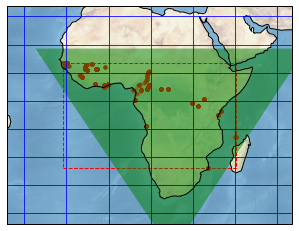

In [18]:
projection=  ccrs.PlateCarree()
transform = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
ax.stock_img()

ax.set_xlim(BBox[0] - 20, BBox[1] + 20)
ax.set_ylim(BBox[2] - 20, BBox[3] + 20)

ax.scatter(
            df_species_samples.longitude,
            df_species_samples.latitude,
            zorder=1, alpha= 0.2, c='r', s=10,
            transform=transform
)

ax.add_patch(
                mpatches.Rectangle(
                    xy=[longitude_min, latitude_min], width=longitude_width, height=latitude_height,
                    edgecolor='red',
                    linestyle='--',
                    fill=False,
                    transform=transform
                )
             )

ax.add_patch(
                mpatches.Polygon(
                    xy=[
                        [longitude_min - 10, latitude_max + 5],
                        [longitude_max + 25, latitude_max + 5],
                        [longitude_max / 2, latitude_min - 30]
                    ],
                    closed=True,
                    facecolor='green',
                    alpha=0.5, 
                    transform=transform
                )

             )

ax.gridlines(color='blue')
ax.coastlines()

plt.show()

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

## Perform PCA over latitude and longitude to find appropriate colours

In [20]:
ccode = pd.Series(pd.Categorical(df_species_samples.country).codes)

color_pal = sns.color_palette("husl", ccode.max() + 1)

plot_colors = ccode.map(lambda y: color_pal[y]).tolist()
color_pal

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9707505829046977, 0.4626541987597626, 0.26486329418330007),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.5310702086647983, 0.6569113639885688, 0.1931838276161326),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.1998437102815942, 0.6927711055021983, 0.4485948481767363),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.22126158707091403, 0.6600977737826563, 0.7915486637100363),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5392573577708815, 0.5821140171749066, 0.9584212824085171),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9082572436765556, 0.40195790729656516, 0.95769

In [37]:
def get_color_scheme(latitudes, longitudes, cmap="jet"):
    
    X_features = np.hstack([latitudes.reshape((-1, 1)), longitudes.reshape((-1, 1))])
    assert X_features.shape[1] == 2

    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)

    pca = PCA()
    pca.fit_transform(X_features)
    pca_variance = pca.explained_variance_

    coordinates = pca.transform(X_features)
    xv = coordinates[:, 0]
    yv = coordinates[:, 1]
    
    cmap_instance = plt.get_cmap(cmap)

    xv_for_map_col = (xv - xv.min())/(xv.max() - xv.min())
    return cmap_instance(xv_for_map_col)

In [50]:
color_scheme = get_color_scheme(all_meta.latitude.values, all_meta.longitude.values, 'gist_rainbow')

In [51]:
cs = pd.DataFrame(color_scheme, index=all_meta.index)

In [52]:
group_colors = cs.loc[sample_names].values
group_colors

array([[0.        , 0.96653879, 1.        , 1.        ],
       [0.        , 0.96653879, 1.        , 1.        ],
       [0.        , 0.96653879, 1.        , 1.        ],
       ...,
       [0.        , 1.        , 0.9276829 , 1.        ],
       [0.        , 1.        , 0.9276829 , 1.        ],
       [0.        , 1.        , 0.9276829 , 1.        ]])

In [53]:
pca_coordinates.shape

(2415, 4)

In [54]:
pca_components.shape

(4, 82912)

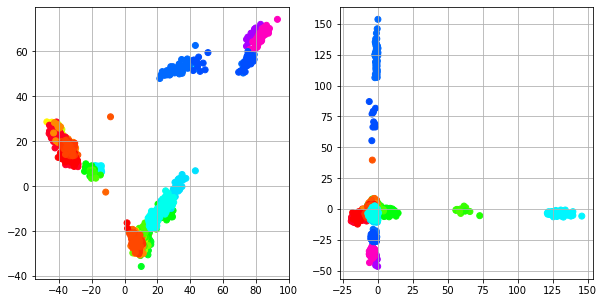

In [55]:
f, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax1, ax2 = ax
ax1.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=group_colors)
ax1.grid(True)

ax2.scatter(pca_coordinates[:, 2], pca_coordinates[:, 3], c=group_colors)
ax2.grid(True)

In [49]:
cs.loc[sample_names].drop_duplicates().shape

(54, 4)

In [120]:
# let's try bokeh...
# imports required for `bokeh`
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.layouts import gridplot

In [144]:
import matplotlib as mpl

def plot_pca_coords(coords, pve, pc1, pc2, fig, df, group_var):

    x = coords[:, pc1]
    y = coords[:, pc2]
    
    qdf = df.reset_index().copy()
    qdf["x"] = x
    qdf["y"] = y
    
    g = qdf.groupby(group_var)
    
    
    for label, frame in g:
        
        source = ColumnDataSource(data=frame)
        
        fig.circle(
            'x', 'y', 
            source=source,
            line_color='black',
            line_width=0.5,
            size=6,
            fill_color=mpl.colors.rgb2hex(pop_colours[label]))
    
    fig.xaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc1 + 1, 100 * pve[pc1])
    
    fig.yaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc2 + 1, 100 * pve[pc2])
    
    return fig

In [145]:
df_species_samples.head()

,location_label,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,,
AR0047-C,group5,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,group5,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,group5,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,group5,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,group5,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [154]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
TOOLTIPS = [
    ("ox_code", "@sample_id"),
    ("country", "@country"),
    ("location", "@location"),
    ("collection year", "@year"),
    ("species", "@species_gambcolu_arabiensis"),
    ("species_gamcol", "@species_gambiae_coluzzii"),
    ("(x, y)", "($x, $y)"),]

In [155]:
#components = np.array(range(8)).reshape((2, 2, 2)).tolist()

In [148]:
components = ([[0, 1]], [[2, 3]])

In [149]:
qlabel = pd.Series(data="", index=cs.index, name="qlabel")
qlabel

sample_id
AR0047-C     
AR0049-C     
AR0051-C     
AR0061-C     
AR0078-C     
           ..
AC0295-C     
AC0296-C     
AC0297-C     
AC0298-C     
AC0299-C     
Name: qlabel, Length: 2784, dtype: object

In [150]:
i = 0
for q, z in cs.groupby([0, 1, 2, 3]).groups.items():
    qlabel.loc[z] = f"group{i}"
    i += 1

In [151]:
f = pd.concat([qlabel, cs], axis=1).set_index("qlabel").drop_duplicates()
pop_colours = {s: x.values for s, x in f.iterrows()}

In [152]:
try:
    df_species_samples.insert(0, "location_label", qlabel.loc[sample_names])
except ValueError:
    pass

In [156]:
output_file("pca_plots.html")
grid = []

for row in components:
    
    l = []
    
    for (c1, c2) in row:

        p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS)
        l.append(
            plot_pca_coords(
                pca_coordinates, 
                [0, 0, 0, 0], 
                c1, 
                c2, 
                p,
                df_species_samples,
                "location_label"))
        
    grid.append(l)

col = gridplot(grid)
show(col)

In [ ]:
plt.scatter(xv, yv, c=alt_cmap_colors)

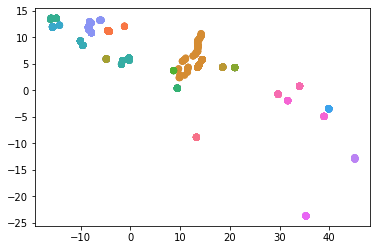

In [29]:
plt.scatter(df_species_samples.longitude, df_species_samples.latitude, c=plot_colors)

In [ ]:
# broadly speaking in an E/W plane.

# 


In [23]:
# https://stackoverflow.com/questions/31967472/smooth-interpolated-tertiary-or-quaternary-colour-scales-e-g-r-g-b-triangle